### What is important to earn money with good work-life balance as a software developer?
Dataset:[Stack Overflow Data-2019 Survey](https://insights.stackoverflow.com/survey/2019)  

Software developers has the image that doing lots of overtime work.
However, there is some of them are having good income and also keeping their work-life balance great.
Naturally, I asked myself: Can I be one of them? Is it too late for me? What should I do for that?
With these question, I did a brief research with the 2019 Stack Overflow’s annual Developer Survey.The survey includes nearly 90,000 developers answer.   

To avoid a group of people who earning money by getting lots of overtime pay, I will look at “hourly income” instead of “annual income” here.  
“hourly income” = “annual income” / “work hours”.  

I will focus on the “satisfied good earner”-people who has good “hourly income” and satisfied with their career .  

For simplicity, abstract data of top 10 appearance of countries:

’United States’, ‘India’, ‘United Kingdom’, ‘Germany’, ‘Canada’, ‘France’, ‘Brazil’, ‘Poland’, ‘Australia’, ‘Netherlands’,
‘Russian Federation’.  

To analyze data clearly, I raised these 4 questions as below.  
1. What programming language is popular in the “satisfied good earner” group?  
2. What kind of database is popular in the “satisfied good earner” group?  
3. How old and how many years coded as professional are they in the “satisfied good earner” group?  
4. What is the key factors to get good “hourly income” in the “satisfied good earner” group?  

P.S.  
1. I chose below columns in survey for simplicity:  
'Employment', 'Country', 'EdLevel', 'OrgSize', 'DevType', 'YearsCodePro', 'MgrWant', 'JobSeek', 'LastHireDate', 'WorkPlan','CareerSat', 'WorkLoc', 'CodeRevHrs', 'LanguageWorkedWith', 'DatabaseWorkedWith', 'OpSys', 'Age', 'Gender', 'Dependents', 'EarningPerHour'.
2. Salary converted to annual USD salaries using the exchange rate on 2019-02-01, 


Gather data: Read the survey csv file to dataframe 

In [52]:
from feature_selector.feature_selector import FeatureSelector

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

'''
#This part is only for the very first time abstract data from original survey data.
df = pd.read_csv('./Data/survey_results_public.csv')
#Only look at professional developers
df = df[df.MainBranch == 'I am a developer by profession']
#To avoid too much data, I only analysis the Top 10 countries here
countries = df.Country.value_counts(ascending = False)[:11]
df = df[df['Country'].isin(countries.index)]
#Remove duplicated data
df.drop_duplicates(keep = 'first', inplace = True)
df.duplicated().sum()
df.to_csv('./Data/survey_results_public_proDev10Countries.csv')
'''

df = pd.read_csv('./Data/survey_results_public_proDev10Countries.csv')
df.shape

(42816, 86)

Assess and clean data

In [25]:
# A function to separate columns including multiple values which separated by ";"
def clean_separate_multivalues(col_list,df):
    df = df.dropna(subset=col_list, axis=0)
    new_df = df.copy()
    for column in col_list:
        new_df = new_df.set_index(new_df.columns.drop(column).to_list())
        new_df = new_df[column].str.split(';', expand=True)
        new_df = \
            (new_df.stack()
            .reset_index()
            .rename(columns={0:column})
            .loc[:, df.columns]
            )
    return new_df

In [26]:
#Calculate compensation per hour, (The survay assuming 12 working months and 50 working weeks)
# Drop rows with missing income related values
df = df.dropna(subset = ['ConvertedComp','WorkWeekHrs'], axis = 0)
df['EarningPerHour'] = df['ConvertedComp']/(df['WorkWeekHrs']*50)
df = df.drop(['ConvertedComp','WorkWeekHrs'],axis =1)
#delete outliers, keep only the ones that are within +3 to -3 standard deviations
df = df[np.abs(df.EarningPerHour-df.EarningPerHour.mean()) <= (3*df.EarningPerHour.std())]

In [27]:
#Change years data type to "int"
df = df.replace('Less than 1 year',0)
df = df.replace('More than 50 years',50)
df['YearsCodePro'] = df['YearsCodePro'].fillna(0).astype(int)

In [28]:
#Take work-life balance good people only
df = df.query('CareerSat == "Very satisfied" or CareerSat == "Slightly satisfied"') 

In [29]:
df.shape

(25684, 85)

Prepare dataframes for each question.
1. What programming language is popular in the “satisfied good earner” group?  
2. What kind of database is popular in the “satisfied good earner” group?  
3. How old and how many years coded as professional are they in the “satisfied good earner” group?  
4. What is the key factors to get good “hourly income” in the “satisfied good earner” group?  

In [30]:
# for Q1,Q2:
col_dev_lang_db =  ['DevType','LanguageWorkedWith', 'DatabaseWorkedWith', 'EarningPerHour']
df_dev_lang_db = df[col_dev_lang_db].copy()
#df_dev_lang_db.drop_duplicates(keep = 'first', inplace = True)

# for Q3: 
col_age = ['YearsCodePro', 'Age', 'EarningPerHour']
df_age = df[col_age].copy()
#df_age.drop_duplicates(keep = 'first', inplace = True)

# for Q4:
col_related = ['Employment','Country', 'EdLevel', 'OrgSize',
                     'DevType', 'YearsCodePro', 
                   'MgrWant', 'JobSeek', 'LastHireDate','WorkPlan','CareerSat',
        'WorkLoc', 'CodeRevHrs','LanguageWorkedWith', 'DatabaseWorkedWith', 'OpSys', 
                   'Age', 'Gender','Dependents','EarningPerHour']

df_related = df[col_related].copy()
df_related.drop_duplicates(keep = 'first', inplace = True)

In [31]:
df_related.shape

(25682, 20)

### Question 1.  What programming language is popular in the "satisfied good earner" group?

In [32]:
df_dev_lang_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25684 entries, 0 to 42814
Data columns (total 4 columns):
DevType               25512 non-null object
LanguageWorkedWith    25621 non-null object
DatabaseWorkedWith    23028 non-null object
EarningPerHour        25684 non-null float64
dtypes: float64(1), object(3)
memory usage: 1003.3+ KB


See the histogram of hourly income

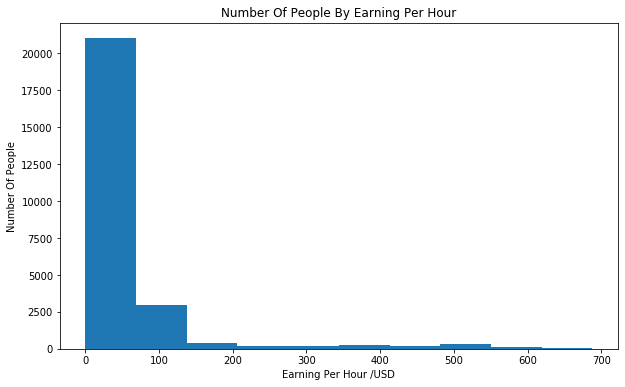

In [35]:
plt.figure(figsize=(10, 6))
df_dev_lang_db.EarningPerHour.plot(kind = 'hist')
plt.title("Number Of People By Earning Per Hour")
plt.xlabel("Earning Per Hour /USD")
plt.ylabel("Number Of People")
plt.savefig('Images/Earning_histogram.png')

We can see most of developers get less than 100 USD per hour.This is reasonable anyway. 
To focus on a group of people “satisfied good earner“, I have abstracted samples with “hourly income” larger than medium value for Question 1,2,3.


In [36]:
df_dev_lang_db = df_dev_lang_db.query('EarningPerHour>{}'.format(np.percentile(df_dev_lang_db['EarningPerHour'],50)))
df_dev_lang_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12842 entries, 2 to 42814
Data columns (total 4 columns):
DevType               12746 non-null object
LanguageWorkedWith    12816 non-null object
DatabaseWorkedWith    11427 non-null object
EarningPerHour        12842 non-null float64
dtypes: float64(1), object(3)
memory usage: 501.6+ KB


Calculate average “hourly income” of each pair of developers type/program languages used. To focus on big amounts, I choose to show only the top 10% of the data in the heat map below.

In [37]:
df_dev_lang_db = clean_separate_multivalues(['DevType','LanguageWorkedWith', 'DatabaseWorkedWith'],df_dev_lang_db)
df_dev_lang = df_dev_lang_db.groupby(['DevType','LanguageWorkedWith']).mean();
df_dev_lang = df_dev_lang.reset_index()
df_dev_lang.head(1)

,DevType,LanguageWorkedWith,EarningPerHour
0,Academic researcher,Assembly,132.294242


Draw heat map figure.

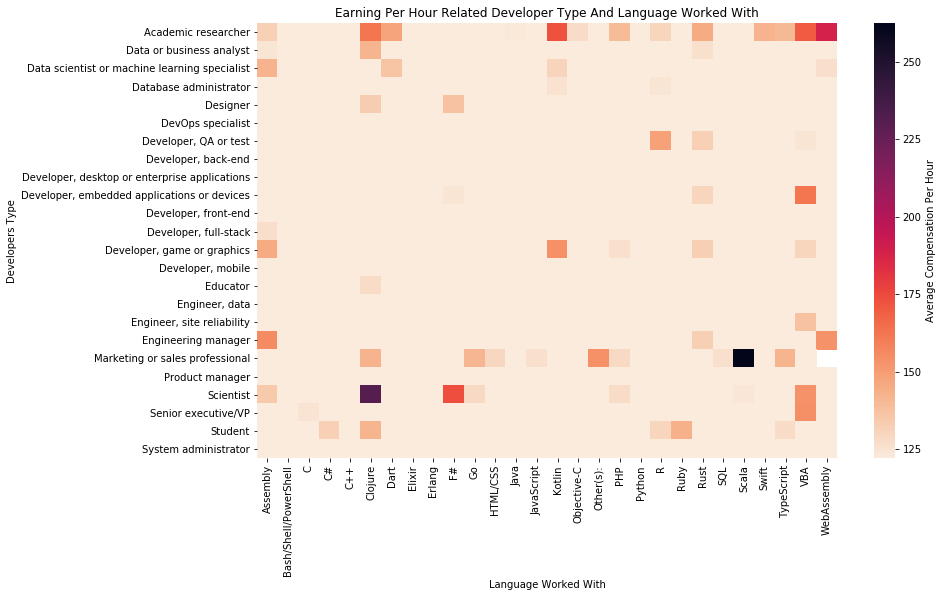

In [38]:
df_dev_lang_pivot = df_dev_lang.pivot(index = 'DevType',
                               columns = 'LanguageWorkedWith',
                               values = 'EarningPerHour')
#set a threshold to show the heat map clearly.
vmin_cut = np.percentile(df_dev_lang['EarningPerHour'],90)
plt.figure(figsize=(13, 8)) 
plt.title('Earning Per Hour Related Developer Type And Language Worked With')
ax = sns.heatmap(df_dev_lang_pivot,cmap = 'rocket_r',vmin = vmin_cut ,cbar = True )
ax.collections[0].colorbar.set_label("Average Compensation Per Hour")
plt.xlabel('Language Worked With')
plt.ylabel('Developers Type')
plt.savefig('Images/Earning_DevLang.png')

The result shows the good “hourly income” appears with developer types:“Academic researcher”, “Marketing or sales professional”, ”Scientist”, Languages: “Assembly”, ”Clojure”, ”VBA”.
Especially, “Marketing or sales professional” who use the language “Scala” have very good “hourly income”.


### Question2.What kind of database is popular in the "satisfied good earner" group?

The same as in the question 1, calculate average “hourly income” of each group set of developers type/Database used. To focus on big amounts, I choose to show only the top 10% of the data in the heat map below.


In [39]:
df_dev_db = df_dev_lang_db.groupby(['DevType','DatabaseWorkedWith']).mean();
df_dev_db = df_dev_db.reset_index()
df_dev_db.head(1)

,DevType,DatabaseWorkedWith,EarningPerHour
0,Academic researcher,Cassandra,155.61433


Draw heat map figure.

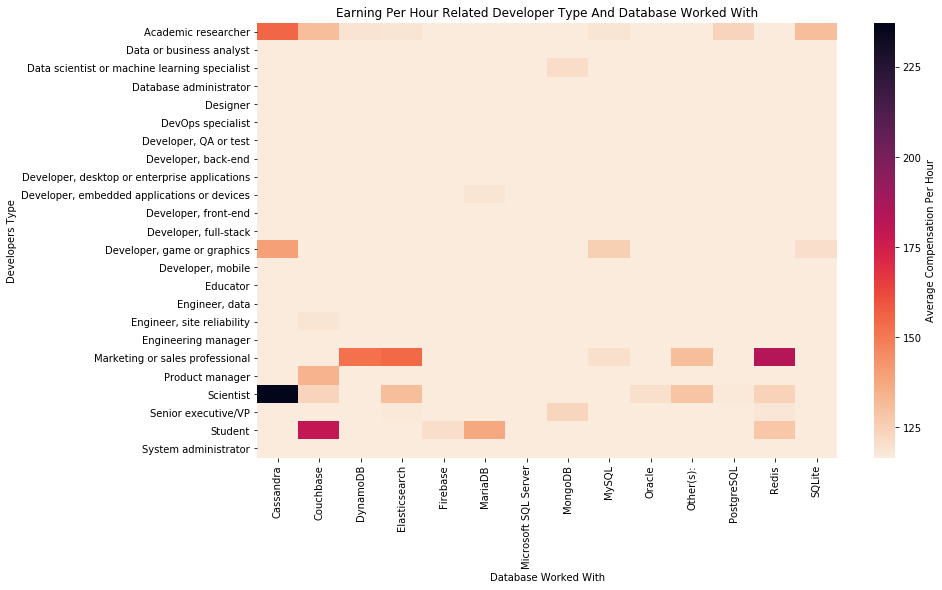

In [40]:
df_dev_db_pivot = df_dev_db.pivot(index = 'DevType',
                               columns = 'DatabaseWorkedWith',
                               values = 'EarningPerHour')
#set a threshold to show the heat map clear.
vmin_cut = np.percentile(df_dev_db['EarningPerHour'],90)
plt.figure(figsize=(13, 8)) 
plt.title('Earning Per Hour Related Developer Type And Database Worked With')
ax = sns.heatmap(df_dev_db_pivot,cmap = 'rocket_r',vmin = vmin_cut,cbar = True )
ax.collections[0].colorbar.set_label("Average Compensation Per Hour")
plt.xlabel('Database Worked With')
plt.ylabel('Developers Type')
plt.savefig('Images/Earning_DevDB.png')

The result shows the good “hourly income” appears with developer types:“Academic researcher”, “Marketing or sales professional”, ”Scientist”, Databases: “Cassandra”, ”Couchbase”, ”Redis”.
Especially, “Scientist” who use the database “Cassandra” have very good “hourly income”.

### Question3. How old and how many years coded as professional are they in the “satisfied good earner” group?  

Calculated average “hourly income” of each pair of Age/Years code professionally and use heat map to show it.

In [41]:
df_age = df_age.query('EarningPerHour>{}'.format(np.percentile(df_age['EarningPerHour'],50)))

In [42]:
df_age = df_age.groupby(['YearsCodePro','Age']).mean();
df_age = df_age.reset_index()
df_age.head(5)

,YearsCodePro,Age,EarningPerHour
0,0,16.0,38.166667
1,0,18.0,60.000000
2,0,19.0,285.555556
3,0,20.0,171.579692
4,0,21.0,115.856571


Draw heat map figure.

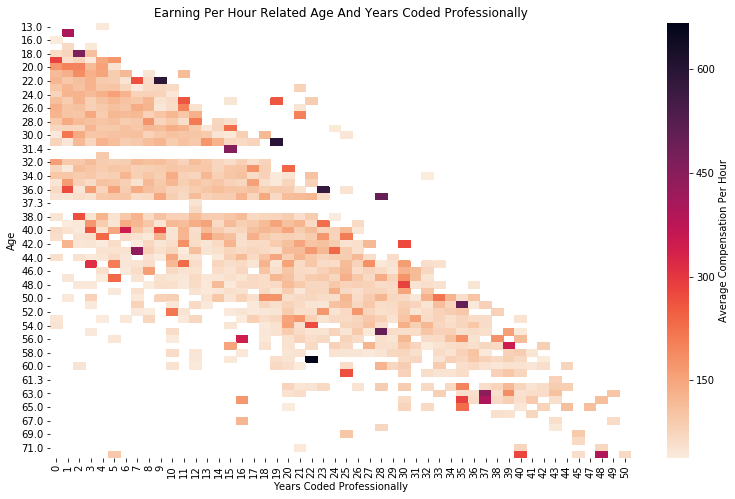

In [43]:
df_age_pivot = df_age.pivot(index = 'Age',
                      columns = 'YearsCodePro',
                      values = 'EarningPerHour'
                     )
plt.figure(figsize=(13, 8))
ax = sns.heatmap(df_age_pivot,cmap = 'rocket_r',cbar = True )
plt.title('Earning Per Hour Related Age And Years Coded Professionally')
plt.xlabel('Years Coded Professionally')
ax.collections[0].colorbar.set_label("Average Compensation Per Hour")
plt.savefig('Images/age_yearscode.png')
plt.show()

As we can see above, the shorter “Years coded Professionally”, the larger amount of people included. It is indicates the advancement in IT and popularity on software development.  

There are darker points in the outside of the figure. It is indicates people with longer code profession experience earns better in the same age. Or, it can be described as: In the same years coded professionally, the youngest group and the oldest group earn better than other.  

The group of people in age around 38–48 earn good in general.  

I was surprised that 18 years old young people are earning good with less than 5 years experience of code as profession. And I was also surprised that people who over than 70 years old are still working as a developer.  

### Question4. What is the key factors to get good “hourly income” in the “satisfied good earner” group?  

In [44]:
df_related.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25682 entries, 0 to 42814
Data columns (total 20 columns):
Employment            25650 non-null object
Country               25682 non-null object
EdLevel               25334 non-null object
OrgSize               25306 non-null object
DevType               25510 non-null object
YearsCodePro          25682 non-null int32
MgrWant               22236 non-null object
JobSeek               25682 non-null object
LastHireDate          25671 non-null object
WorkPlan              25224 non-null object
CareerSat             25682 non-null object
WorkLoc               25547 non-null object
CodeRevHrs            20565 non-null float64
LanguageWorkedWith    25619 non-null object
DatabaseWorkedWith    23026 non-null object
OpSys                 25553 non-null object
Age                   24751 non-null float64
Gender                25258 non-null object
Dependents            25141 non-null object
EarningPerHour        25682 non-null float64
dtypes: f

There is some numeric missing data need to handle.   
Because I have enough data to analysis,I choose to drop these null data instead of fill it.

In [45]:
num_vars = df_related.select_dtypes(include=['float', 'int']).columns
for col in num_vars:

    df_related.dropna(subset = [col], inplace=True)

In [46]:
# Separate columns including multiple values which separated by ";"
col_list = ['DevType','LanguageWorkedWith', 'DatabaseWorkedWith']
new_df = clean_separate_multivalues(col_list,df_related)
new_df.shape

(1109001, 20)

In [47]:
# check if there is any ';'' remain and need to remove
cat_columns = new_df.select_dtypes(include=['object']).copy().columns
for column in cat_columns:
    if new_df[column].str.contains(";").sum():
        print(column)

WorkPlan
Gender


A way to decide which factors are important to "satisfied good earner", I use a library called [feature_selector](https://github.com/WillKoehrsen/feature-selector), which behind the scene utilizing a gradient boosting machine implemented in the [LightGBM library](https://lightgbm.readthedocs.io/en/latest/Quick-Start.html).
A blog post on how to use this package can be found [here](https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0).

This module relies on a machine learning model to identify features to remove. It therefore requires a supervised learning problem with labels. 

Categorize ‘EarningPerHour’ column to 2 values: one is earning over than medium value,another is lower than medium value.

In [48]:
bins = [-0.5,np.percentile(new_df['EarningPerHour'],50),np.max(new_df['EarningPerHour'])]
labels=['Cat{}'.format(x) for x in range(1, len(bins))]
y = pd.cut(new_df['EarningPerHour'], bins=bins, labels=labels)


In [49]:
#Check whether there is anything lost.
y.isna().sum()

0

In [53]:
X = new_df.drop(['EarningPerHour'],axis = 1)
fs = FeatureSelector(data = X, labels = y)

In [54]:
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.993381	valid_0's binary_logloss: 0.147782
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.992583	valid_0's binary_logloss: 0.149998
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.993177	valid_0's binary_logloss: 0.146512
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.99306	valid_0's binary_logloss: 0.148029
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.992883	valid_0's binary_logloss: 0.148933
Training until validation scores don't improve for 100 rounds
Did not meet early stoppi

In [55]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[10:15]
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,Age,3987.6,0.132920,0.132920
1,YearsCodePro,3872.1,0.129070,0.261990
2,CodeRevHrs,2874.5,0.095817,0.357807
3,CareerSat_Slightly satisfied,608.8,0.020293,0.378100
4,OpSys_Windows,541.0,0.018033,0.396133
5,Country_United States,529.7,0.017657,0.413790
6,"EdLevel_Bachelor’s degree (BA, BS, B.Eng., etc.)",508.4,0.016947,0.430737
7,WorkPlan_There is a schedule and/or spec (made...,481.3,0.016043,0.446780
8,LastHireDate_Less than a year ago,464.4,0.015480,0.462260
9,MgrWant_No,460.1,0.015337,0.477597


Plot the results.

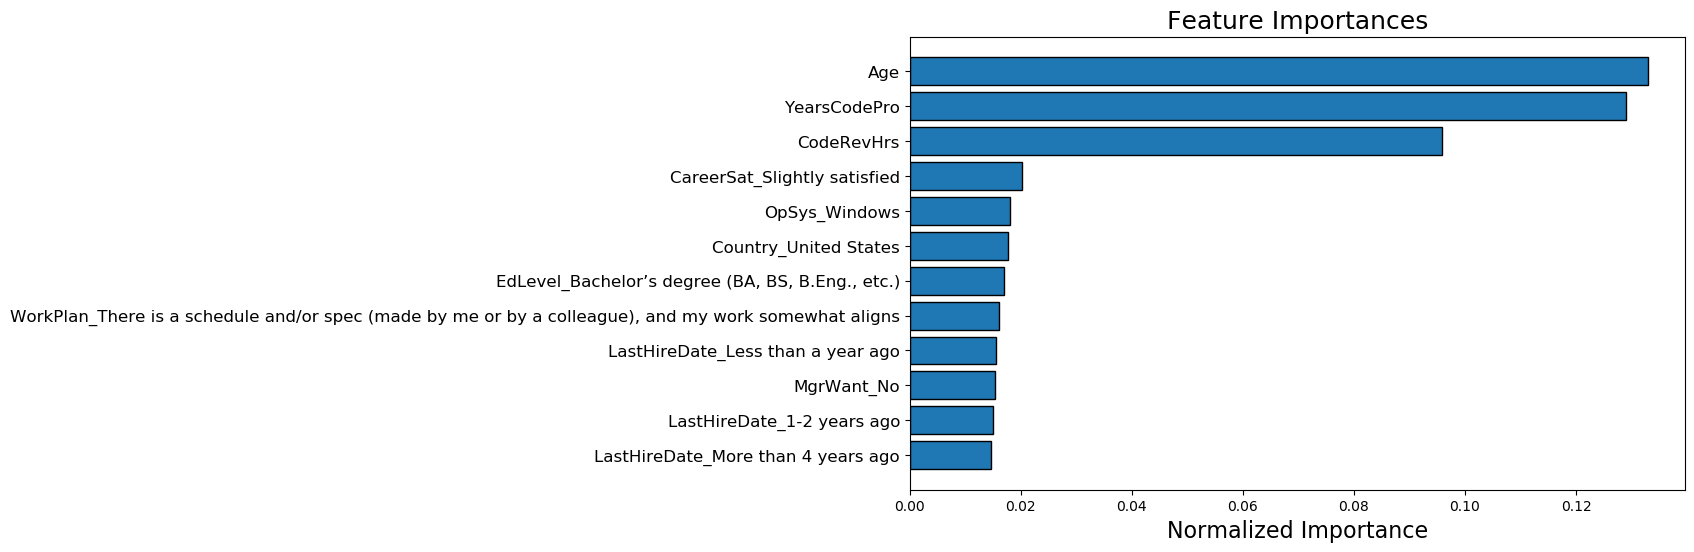

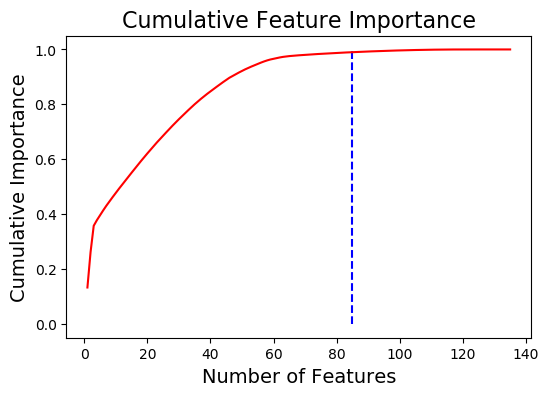

85 features required for 0.99 of cumulative importance


<Figure size 640x480 with 0 Axes>

In [56]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)
plt.savefig('Images/Factors.png')

The result shows that “Age” and “Years code as profession” is very important to get a good hourly income.  
The “code review hours” occupy the third places, it is indicating that longer time with code review are related to get more hourly income.  
From the fourth factors like “slightly satisfied in career”, “using windows system”, ”live in united states” might have subtle influences on hourly income, but not very strong.  

**Conclusions:**  
+ If one person in around age 38–48 who taking lots of time to review code,and codde as profession many years, he/she has big chance to have good hourly income and work-life balance.
+ In the same age, people with longer code profession experience can earn better. Also, with the same years coded professionally, the youngest group and the oldest group earn better.
+ Good “hourly income” appears with developer types:“Academic researcher”, “Marketing or sales professional”, ”Scientist”, Languages: “Assembly”, ”Clojure”, ”VBA”.
+ Especially, “Marketing or sales professional” who use the language “Scala” have very good “hourly income”.
+ Good “hourly income” appears with Databases: “Cassandra”, ”Couchbase”, ”Redis”.
+ Especially, “Scientist” who use the database “Cassandra” have very good “hourly income”.